In [ ]:
import torch
import torch.nn as nn
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp
#!pip install tikzplotlib #uncomment for saving nice images
#import tikzplotlib
# set precision
torch.set_default_dtype(torch.float64)
print('Default data type:', torch.get_default_dtype())

Default data type: torch.float64


In [ ]:
import os, torch, pickle, zipfile, sys
import imageio, shutil
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp



In [ ]:
!pip install hessquik
import hessQuik.activations as act
import hessQuik.layers as lay
import hessQuik.networks as net
from hessQuik.utils import  test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#data set from !!!
# Hamiltonian Neural Networks | 2019
# Sam Greydanus, Misko Dzamba, Jason Yosinski
#https://github.com/greydanus/hamiltonian-nn/blob/master/experiment-3body/data.py

def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=pickle.HIGHEST_PROTOCOL)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

##### ENERGY #####
def potential_energy(state):
    '''U=\sum_i,j>i G m_i m_j / r_ij'''
    tot_energy = np.zeros((1,1,state.shape[2]))
    for i in range(state.shape[0]):
        for j in range(i+1,state.shape[0]):
            r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
            m_i = state[i:i+1,0:1]
            m_j = state[j:j+1,0:1]
            tot_energy += m_i * m_j / r_ij
    U = -tot_energy.sum(0).squeeze()
    return U

def kinetic_energy(state):
    '''T=\sum_i .5*m*v^2'''
    energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
    T = energies.sum(0).squeeze()
    return T

def total_energy(state):
    return potential_energy(state) + kinetic_energy(state)


##### DYNAMICS #####
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs
  
def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
    deriv[:,3:5] = get_accelerations(state)
    return deriv.reshape(-1)


##### INTEGRATION SETTINGS #####
def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], nbodies=3, **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies, 5, t_points)
    return orbit, orbit_settings


##### INITIALIZE THE TWO BODIES #####
def rotate2d(p, theta):
  c, s = np.cos(theta), np.sin(theta)
  R = np.array([[c, -s],[s, c]])
  return (R @ p.reshape(2,1)).squeeze()

def random_config(nu=2e-1, min_radius=0.9, max_radius=1.2):
  '''This is not principled at all yet'''
  state = np.zeros((3,5))
  state[:,0] = 1
  p1 = 2*np.random.rand(2) - 1
  r = np.random.rand() * (max_radius-min_radius) + min_radius
  
  p1 *= r/np.sqrt( np.sum((p1**2)) )
  p2 = rotate2d(p1, theta=2*np.pi/3)
  p3 = rotate2d(p2, theta=2*np.pi/3)

  # # velocity that yields a circular orbit
  v1 = rotate2d(p1, theta=np.pi/2)
  v1 = v1 / r**1.5
  v1 = v1 * np.sqrt(np.sin(np.pi/3)/(2*np.cos(np.pi/6)**2)) # scale factor to get circular trajectories
  v2 = rotate2d(v1, theta=2*np.pi/3)
  v3 = rotate2d(v2, theta=2*np.pi/3)
  
  # make the circular orbits slightly chaotic
  v1 *= 1 + nu*(2*np.random.rand(2) - 1)
  v2 *= 1 + nu*(2*np.random.rand(2) - 1)
  v3 *= 1 + nu*(2*np.random.rand(2) - 1)

  state[0,1:3], state[0,3:5] = p1, v1
  state[1,1:3], state[1,3:5] = p2, v2
  state[2,1:3], state[2,3:5] = p3, v3
  return state


##### INTEGRATE AN ORBIT OR TWO #####
def sample_orbits(timesteps=20, trials=5000, nbodies=3, orbit_noise=2e-1,
                  min_radius=0.9, max_radius=1.2, t_span=[0, 5], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 3-body orbits:")
    
    x, dx, e = [], [], []
    N = timesteps*trials
    while len(x) < N:

        state = random_config(nu=orbit_noise, min_radius=min_radius, max_radius=max_radius)
        orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, nbodies=nbodies, **kwargs)
        batch = orbit.transpose(2,0,1).reshape(-1,nbodies*5)

        for state in batch:
            dstate = update(None, state)
            
            # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
            # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
            coords = state.reshape(nbodies,5).T[1:].flatten()
            dcoords = dstate.reshape(nbodies,5).T[1:].flatten()
            x.append(coords)
            dx.append(dcoords)

            shaped_state = state.copy().reshape(nbodies,5,1)
            e.append(total_energy(shaped_state))

    data = {'coords': np.stack(x)[:N],
            'dcoords': np.stack(dx)[:N],
            'energy': np.stack(e)[:N] }
    return data, orbit_settings


##### MAKE A DATASET #####
def make_orbits_dataset(test_split=0.2, **kwargs):
    data, orbit_settings = sample_orbits(**kwargs)
    
    # make a train/test split
    split_ix = int(data['coords'].shape[0] * test_split)
    split_data = {}
    for k, v in data.items():
        split_data[k], split_data['test_' + k] = v[split_ix:], v[:split_ix]
    data = split_data

    data['meta'] = orbit_settings
    return data


##### LOAD OR SAVE THE DATASET #####
def get_dataset(experiment_name, save_dir, **kwargs):
    '''Returns an orbital dataset. Also constructs
    the dataset if no saved version is available.'''

    path = '{}/{}-orbits-dataset.pkl'.format(save_dir, experiment_name)

    try:
        data = from_pickle(path)
        print("Successfully loaded data from {}".format(path))
    except:
        print("Had a problem loading data from {}. Rebuilding dataset...".format(path))
        data = make_orbits_dataset(**kwargs)
        to_pickle(data, path)

    return data

In [ ]:
n_train = 2000      # number of training points
n_val = 300         # number of validation points
n_test = 300        # number of testing points
#import data and assign each array to a different value
import numpy as np
from pathlib import Path
data = get_dataset("3BodyData", "", verbose=True)

timesteps = []
for x in range(80000):
  timesteps += [x]
data["timestep"] = timesteps 
del data["dcoords"]
del data["test_dcoords"]
del data["test_energy"]
del data["meta"]
del data["test_coords"]


#data goes qx1 qx2 qx3, qy1 qy2 qy3, px1 px2 px3, py1 py2 py3 we think


Had a problem loading data from /3BodyData-orbits-dataset.pkl. Rebuilding dataset...
Making a dataset of near-circular 3-body orbits:


In [ ]:

px1 = []
px2 = []
px3 = []
qx1 = []
qx2 = []
qx3 = []
py1 = []
py2 = []
py3 = []
qy1 = []
qy2 = []
qy3 = []
for x in data["coords"]:
  for y in range(len(x)):
    if y % 12 == 0:
      px1 += [x[y]]
    elif y % 12 == 1:
      px2 += [x[y]]
    elif y % 12 == 2:
      px3 += [x[y]]
    elif y % 12 == 3:
      py1 += [x[y]]
    elif y % 12 == 4:
      py2 += [x[y]]
    elif y % 12 == 5:
      py3 += [x[y]]
    elif y % 12 == 6:
      qx1 += [x[y]]
    elif y % 12 == 7:
      qx2 += [x[y]]
    elif y % 12 == 8:
      qx3 += [x[y]]
    elif y % 12 == 9:
      qy1 += [x[y]]
    elif y % 12 == 10:
      qy2 += [x[y]]
    elif y % 12 == 11:
      qy3 += [x[y]]
    


In [ ]:
print(len(qx2))
for x in range(3):
  print(px1[x])

80000
0.7781306889871661
0.9235967237073314
1.0412723488583533


In [ ]:
#these are the tensors of our data
px1Data =  np.reshape(px1,[-1,1])

px2Data =  np.reshape(px2,[-1,1])
px3Data =  np.reshape(px3,[-1,1])
qx1Data =  np.reshape(qx1,[-1,1])
qx2Data =  np.reshape(qx2,[-1,1])
qx3Data =   np.reshape(qx3,[-1,1])
py1Data =  np.reshape(py1,[-1,1]) 
py2Data =  np.reshape(py2,[-1,1])
py3Data =  np.reshape(py3,[-1,1])
qy1Data =  np.reshape(qy1,[-1,1])
qy2Data =   np.reshape(qy2,[-1,1])
qy3Data =  np.reshape(qy3,[-1,1])
timeStep = np.reshape(data["timestep"],[-1,1])
# assign data to x and y

x = np.concatenate([timeStep,px1Data,px2Data,px3Data,py1Data,py2Data,py3Data,qx1Data,qx2Data,qx3Data,qy1Data,qy2Data,qy3Data],axis=1) #combine the y and z data 
x = torch.tensor(x)
y = np.concatenate([px1Data,px2Data,px3Data,py1Data,py2Data,py3Data,qx1Data,qx2Data,qx3Data,qy1Data,qy2Data,qy3Data],axis =1 )
y = torch.tensor(y)

# no shuffling
n_samples = n_train
x_train, y_train = x[:n_train], y[1:n_train+1]
x_val, y_val = x_train[3:17], y_train[3:17]
x_test, y_test = x_train[7:28], y_train[7:28]

print(x_train.size())
print(y_train.size())
# shuffle and split data
# idx = torch.randperm(n_train + n_val + n_test)
# x_train, y_train = x[idx[:n_train]], y[idx[:n_train]]
# x_val, y_val = x[idx[n_train:n_train + n_val]], y[idx[n_train:n_train + n_val]]
# x_test, y_test = x[idx[n_train + n_val:]], y[idx[n_train + n_val:]]

stepSize = (x_train[1,0] - x_train[0,0])
print("stepsize=", stepSize)

torch.Size([2000, 13])
torch.Size([2000, 12])
stepsize= tensor(1.)


In [ ]:
width = 20
depth = 3
f = net.NN(lay.singleLayer(13, width, act=act.tanhActivation()),
           net.resnetNN(width, depth, h=0.5, act=act.tanhActivation()),
           lay.singleLayer(width, 1, act=act.identityActivation()))
#print(f)
# Pytorch optimizer for the network weights
optimizer = torch.optim.Adam(f.parameters(), lr=1e-3) #weight decay is for regularization weight_decay=1e-5 add this for regularization


In [ ]:
def mse_loss(y_true: torch.Tensor,y: torch.Tensor):
  return (0.5 / y.shape[0]) * torch.norm(y_true - y.view_as(y_true)) ** 2

In [ ]:
def print_headers( verbose: bool = True):
    r"""
    Print headers for nice training
    """
    loss_printouts = ('loss',)
    n_loss = len(loss_printouts)

    headers = (('', '', '|', 'running',) + (n_loss - 1) * ('',) + ('|', 'train',)
               + (n_loss - 1) * ('',) + ('|', 'valid',) + (n_loss - 1) * ('',))

    printouts = ('epoch', 'time') + 3 * (('|',) + loss_printouts)
    printouts_frmt = '{:<15d}{:<15.4f}' + 3 * ('{:<2s}' + n_loss * '{:<15.4e}')

    if verbose:
        print(('{:<15s}{:<15s}' + 3 * ('{:<2s}' + n_loss * '{:<15s}')).format(*headers))
        print(('{:<15s}{:<15s}' + 3 * ('{:<2s}' + n_loss * '{:<15s}')).format(*printouts))

    return headers, printouts, printouts_frmt

                              | running        | train          | valid          
epoch          time           | loss           | loss           | loss           
0              0.0724         | 4.2031e-01     | 4.1964e-01     | 4.3675e-01     
5              0.0608         | 4.1803e-01     | 4.1776e-01     | 3.5584e-01     
10             0.0582         | 4.1696e-01     | 4.1681e-01     | 3.0224e-01     
15             0.0591         | 4.1636e-01     | 4.1628e-01     | 2.6813e-01     
20             0.0602         | 4.1602e-01     | 4.1596e-01     | 2.4704e-01     
25             0.0608         | 4.1580e-01     | 4.1577e-01     | 2.3395e-01     
30             0.0607         | 4.1567e-01     | 4.1565e-01     | 2.2532e-01     
35             0.0564         | 4.1557e-01     | 4.1555e-01     | 2.1880e-01     
40             0.0593         | 4.1549e-01     | 4.1547e-01     | 2.1298e-01     
45             0.0589         | 4.1541e-01     | 4.1539e-01     | 2.0720e-01     
50             0

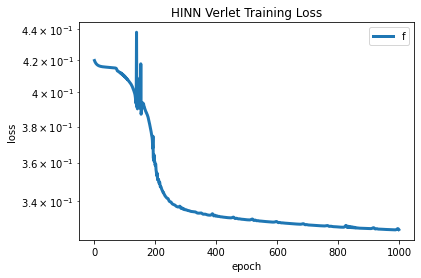

In [ ]:
# training parameters
max_epochs = 1000
batch_size = n_samples

# get printouts
headers, printouts_str, printouts_frmt = print_headers()

# ---------------------------------------------------------------------------- #
# initial evaluation
f_train = f(x_train,do_gradient=True,do_hessian = False) 
#now construct the neural nets for validation

f_val = f(x_val,do_gradient=True,do_hessian = False)
#loss_val = mse_loss(torch.cat((yTimeOneVal,zTimeOneVal),dim=1),y_val)
fpx1 = ((f_train[1])[:,1,:]) #The y data from our net
fpx2 = ((f_train[1])[:,2,:]) #the z data from our net
fpx3 = ((f_train[1])[:,3,:]) #The y data from our net
fpy1 = ((f_train[1])[:,4,:]) #the z data from our net
fpy2 = ((f_train[1])[:,5,:]) #The y data from our net
fpy3 = ((f_train[1])[:,6,:]) #the z data from our net
fqx1 = ((f_train[1])[:,7,:]) #The y data from our net
fqx2 = ((f_train[1])[:,8,:]) #the z data from our net
fqx3 = ((f_train[1])[:,9,:]) #The y data from our net
fqy1 = ((f_train[1])[:,10,:]) #the z data from our net
fqy2 = ((f_train[1])[:,11,:]) #The y data from our net
fqy3 = ((f_train[1])[:,12,:]) #the z data from our net

px1TimeOneVal = 1 * stepSize*fqx1  + x_train[:,1:2]
px2TimeOneVal = 1 * stepSize*fqx2 + x_train[:,2:3]
px3TimeOneVal = 1 *stepSize*fqx3  + x_train[:,3:4]
py1TimeOneVal = 1 * stepSize*fqy1 + x_train[:,4:5]
py2TimeOneVal = 1 * stepSize*fqy2  + x_train[:,5:6]
py3TimeOneVal = 1 * stepSize*fqy3 + x_train[:,6:7]
qx1TimeOneVal = -1 * stepSize*fpx1  + x_train[:,7:8]
qx2TimeOneVal = -1 * stepSize*fpx2 + x_train[:,8:9]
qx3TimeOneVal = -1 * stepSize*fpx3  + x_train[:,9:10]
qy1TimeOneVal = -1 * stepSize*fpy1 + x_train[:,10:11]
qy2TimeOneVal = -1 * stepSize*fpy2  + x_train[:,11:12]
qy3TimeOneVal = -1 * stepSize*fpy3 + x_train[:,12:13]

#For printing: 

his_iter = (-1, 0.0) + ('|',) + (0,) + ('|',) + (0,) + ('|',) + (0,)
# print(printouts_frmt.format(*his_iter))

# store history
his = np.array([x for x in his_iter if not (x == '|')]).reshape(1, -1)
# ---------------------------------------------------------------------------- #
# main iteration

log_interval = 5 # how often printouts appear
for epoch in range(max_epochs):
    t0 = time.perf_counter()
    # training here
    f.train()
    n = x_train.shape[0]
    b = batch_size
    n_batch = n // b
    loss = torch.zeros(1)
    running_loss = 0.0

    # shuffle
    idx = torch.randperm(n) #identity?

    for i in range(n_batch):
        idxb = idx[i * b:(i + 1) * b] #random permute based on batch number
        xb, yb = x_train[idxb], y_train[idxb] #get that batch data
        optimizer.zero_grad()
        f_batch= f(xb,do_gradient=True,do_hessian = False) 
        #print(f_batch)
        fbpx1 = ((f_batch[1])[:,1,:]) #y from the batch
        fbpx2 = ((f_batch[1])[:,2,:]) #y from the batch
        fbpx3 = ((f_batch[1])[:,3,:]) #y from the batch
        fbpy1 = ((f_batch[1])[:,4,:]) #y from the batch
        fbpy2 = ((f_batch[1])[:,5,:]) #y from the batch
        fbpy3 = ((f_batch[1])[:,6,:]) #y from the batch
        fbqx1 = ((f_batch[1])[:,7,:]) #y from the batch
        fbqx2 = ((f_batch[1])[:,8,:]) #y from the batch
        fbqx3 = ((f_batch[1])[:,9,:]) #y from the batch
        fbqy1 = ((f_batch[1])[:,10,:]) #y from the batch
        fbqy2 = ((f_batch[1])[:,11,:]) #y from the batch
        fbqy3 = ((f_batch[1])[:,12,:]) #y from the batch
        
        # unstable?     -> huh?
        px1TimeOneVal = 1 * stepSize*fbqx1  + xb[:,1:2]
        px2TimeOneVal = 1 * stepSize*fbqx2 + xb[:,2:3]
        px3TimeOneVal = 1 *stepSize*fbqx3  + xb[:,3:4]
        py1TimeOneVal = 1 * stepSize*fbqy1 + xb[:,4:5]
        py2TimeOneVal = 1 * stepSize*fbqy2  + xb[:,5:6]
        py3TimeOneVal = 1 * stepSize*fbqy3 + xb[:,6:7]
        qx1TimeOneVal = -1 * stepSize*fbpx1  + xb[:,7:8]
        qx2TimeOneVal = -1 * stepSize*fbpx2 + xb[:,8:9]
        qx3TimeOneVal = -1 * stepSize*fbpx3  + xb[:,9:10]
        qy1TimeOneVal = -1 * stepSize*fbpy1 + xb[:,10:11]
        qy2TimeOneVal = -1 * stepSize*fbpy2  + xb[:,11:12]
        qy3TimeOneVal = -1 * stepSize*fbpy3 + xb[:,12:13]

        # stable
        # yTimeOneVal = stepSize*fb2  + xb[:,1:2]
        # zTimeOneVal = -1 * stepSize*yTimeOneVal + xb[:,2:3] # think about higher order verlet
        loss = mse_loss(torch.cat((px1TimeOneVal,px2TimeOneVal,px3TimeOneVal,py1TimeOneVal,py2TimeOneVal,py3TimeOneVal,qx1TimeOneVal,qx2TimeOneVal,qx3TimeOneVal,qy1TimeOneVal,qy2TimeOneVal,qy3TimeOneVal),dim=1),yb)
        running_loss += b * loss.item()

        # update network weights
        loss.backward(retain_graph=True)
        optimizer.step()

    running_loss = (running_loss / n,)
    
    t1 = time.perf_counter()

    # test
    fc_train= f(x_train,do_gradient=True,do_hessian = False)

    px1TimeOneVal = 1 * stepSize*fc_train[1][:,7,:].detach()  + x_train[:,1:2]
    px2TimeOneVal = 1 * stepSize*fc_train[1][:,8,:].detach() + x_train[:,2:3]
    px3TimeOneVal = 1 *stepSize*fc_train[1][:,9,:].detach()  + x_train[:,3:4]
    py1TimeOneVal = 1 * stepSize*fc_train[1][:,10,:].detach() + x_train[:,4:5]
    py2TimeOneVal = 1 * stepSize*fc_train[1][:,11,:].detach()  + x_train[:,5:6]
    py3TimeOneVal = 1 * stepSize*fc_train[1][:,12,:].detach() + x_train[:,6:7]
    qx1TimeOneVal = -1 * stepSize*fc_train[1][:,1,:].detach()  + x_train[:,7:8]
    qx2TimeOneVal = -1 * stepSize*fc_train[1][:,2,:].detach() + x_train[:,8:9]
    qx3TimeOneVal = -1 * stepSize*fc_train[1][:,3,:].detach()  + x_train[:,9:10]
    qy1TimeOneVal = -1 * stepSize*fc_train[1][:,4,:].detach() + x_train[:,10:11]
    qy2TimeOneVal = -1 * stepSize*fc_train[1][:,5,:].detach()  + x_train[:,11:12]
    qy3TimeOneVal = -1 * stepSize*fc_train[1][:,6,:].detach() + x_train[:,12:13]





    loss_train = mse_loss(torch.cat((px1TimeOneVal,px2TimeOneVal,px3TimeOneVal,py1TimeOneVal,py2TimeOneVal,py3TimeOneVal,qx1TimeOneVal,qx2TimeOneVal,qx3TimeOneVal,qy1TimeOneVal,qy2TimeOneVal,qy3TimeOneVal),dim=1),y_train)

    fc_val= f(x_val,do_gradient=True,do_hessian = False)

    px1TimeOneVal = 1 * stepSize*fc_val[1][:,7,:].detach()  + x_val[:,1:2]
    px2TimeOneVal = 1 * stepSize*fc_val[1][:,8,:].detach() + x_val[:,2:3]
    px3TimeOneVal = 1 *stepSize*fc_val[1][:,9,:].detach()  + x_val[:,3:4]
    py1TimeOneVal = 1 * stepSize*fc_val[1][:,10,:].detach() + x_val[:,4:5]
    py2TimeOneVal = 1 * stepSize*fc_val[1][:,11,:].detach()  + x_val[:,5:6]
    py3TimeOneVal = 1 * stepSize*fc_val[1][:,12,:].detach() + x_val[:,6:7]
    qx1TimeOneVal = -1 * stepSize*fc_val[1][:,1,:].detach()  + x_val[:,7:8]
    qx2TimeOneVal = -1 * stepSize*fc_val[1][:,2,:].detach() + x_val[:,8:9]
    qx3TimeOneVal = -1 * stepSize*fc_val[1][:,3,:].detach()  + x_val[:,9:10]
    qy1TimeOneVal = -1 * stepSize*fc_val[1][:,4,:].detach() + x_val[:,10:11]
    qy2TimeOneVal = -1 * stepSize*fc_val[1][:,5,:].detach()  + x_val[:,11:12]
    qy3TimeOneVal = -1 * stepSize*fc_val[1][:,6,:].detach() + x_val[:,12:13]

    loss_val = mse_loss(torch.cat((px1TimeOneVal,px2TimeOneVal,px3TimeOneVal,py1TimeOneVal,py2TimeOneVal,py3TimeOneVal,qx1TimeOneVal,qx2TimeOneVal,qx3TimeOneVal,qy1TimeOneVal,qy2TimeOneVal,qy3TimeOneVal),dim=1),y_val)

    t = t1-t0
    his_iter = (epoch, t1 - t0) + ('|',) + running_loss + ('|',) + (loss_train.item(),) + ('|',) + (loss_val.item(),)
    if epoch % log_interval == 0:
      print(printouts_frmt.format(*his_iter))

    # store history
    idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]
    his = np.concatenate((his, np.array([x for x in his_iter if not (x == '|')]).reshape(1, -1)), axis=0)
# ---------------------------------------------------------------------------- #
# overall performance on test data
f_test= f(x_test,do_gradient=True,do_hessian = False)
px1TimeOneVal = 1 * stepSize*f_test[1][:,7,:].detach()  + x_test[:,1:2]
px2TimeOneVal = 1 * stepSize*f_test[1][:,8,:].detach() + x_test[:,2:3]
px3TimeOneVal = 1 *stepSize*f_test[1][:,9,:].detach()  + x_test[:,3:4]
py1TimeOneVal = 1 * stepSize*f_test[1][:,10,:].detach() + x_test[:,4:5]
py2TimeOneVal = 1 * stepSize*f_test[1][:,11,:].detach()  + x_test[:,5:6]
py3TimeOneVal = 1 * stepSize*f_test[1][:,12,:].detach() + x_test[:,6:7]
qx1TimeOneVal = -1 * stepSize*f_test[1][:,1,:].detach()  + x_test[:,7:8]
qx2TimeOneVal = -1 * stepSize*f_test[1][:,2,:].detach() + x_test[:,8:9]
qx3TimeOneVal = -1 * stepSize*f_test[1][:,3,:].detach()  + x_test[:,9:10]
qy1TimeOneVal = -1 * stepSize*f_test[1][:,4,:].detach() + x_test[:,10:11]
qy2TimeOneVal = -1 * stepSize*f_test[1][:,5,:].detach()  + x_test[:,11:12]
qy3TimeOneVal = -1 * stepSize*f_test[1][:,6,:].detach() + x_test[:,12:13]

loss_test = mse_loss(torch.cat((px1TimeOneVal,px2TimeOneVal,px3TimeOneVal,py1TimeOneVal,py2TimeOneVal,py3TimeOneVal,qx1TimeOneVal,qx2TimeOneVal,qx3TimeOneVal,qy1TimeOneVal,qy2TimeOneVal,qy3TimeOneVal),dim=1),y_test)
print('Test Loss: %0.4e' % loss.item())

# convergence plots
fig = plt.figure()
linewidth = 3
idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]

plt.semilogy(his[1::, 0], his[1::, idx], linewidth=linewidth, label='f')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('HINN Verlet Training Loss') 
plt.legend()
plt.show()
#fig.savefig('conv_plot.png',dpi=300) #to save the image

In [ ]:
# overall performance on test data
fb= f(x_test,do_gradient=True,do_hessian = False)

px1TimeOneVal = 1 * stepSize*fb[1][:,7,:].detach()  + x_test[:,1:2]
px2TimeOneVal = 1 * stepSize*fb[1][:,8,:].detach() + x_test[:,2:3]
px3TimeOneVal = 1 *stepSize*fb[1][:,9,:].detach()  + x_test[:,3:4]
py1TimeOneVal = 1 * stepSize*fb[1][:,10,:].detach() + x_test[:,4:5]
py2TimeOneVal = 1 * stepSize*fb[1][:,11,:].detach()  + x_test[:,5:6]
py3TimeOneVal = 1 * stepSize*fb[1][:,12,:].detach() + x_test[:,6:7]
qx1TimeOneVal = -1 * stepSize*fb[1][:,1,:].detach()  + x_test[:,7:8]
qx2TimeOneVal = -1 * stepSize*fb[1][:,2,:].detach() + x_test[:,8:9]
qx3TimeOneVal = -1 * stepSize*fb[1][:,3,:].detach()  + x_test[:,9:10]
qy1TimeOneVal = -1 * stepSize*fb[1][:,4,:].detach() + x_test[:,10:11]
qy2TimeOneVal = -1 * stepSize*fb[1][:,5,:].detach()  + x_test[:,11:12]
qy3TimeOneVal = -1 * stepSize*fb[1][:,6,:].detach() + x_test[:,12:13]

loss_test = mse_loss(torch.cat((px1TimeOneVal,px2TimeOneVal,px3TimeOneVal,py1TimeOneVal,py2TimeOneVal,py3TimeOneVal,qx1TimeOneVal,qx2TimeOneVal,qx3TimeOneVal,qy1TimeOneVal,qy2TimeOneVal,qy3TimeOneVal),dim=1),y_test)

print('Test Loss: %0.4e' % loss.item())

Test Loss: 3.2581e-01


In [ ]:
t, px1, px2,px3,py1,py2,py3,qx1,qx2,qx3,qy1,qy2,qy3 = x_train[0:1,0:1], x_train[0:1,1:2], x_train[0:1,2:3] ,x_train[0:1,3:4],x_train[0:1,4:5], x_train[0:1,5:6] ,x_train[0:1,6:7],x_train[0:1,7:8], x_train[0:1,8:9] ,x_train[0:1,9:10],x_train[0:1,10:11], x_train[0:1,11:12] ,x_train[0:1,12:13],
steps = n_samples
h = stepSize
sol = torch.zeros(steps,14)
for i in range(steps):

  fb = f(torch.cat((t, px1, px2,px3,py1,py2,py3,qx1,qx2,qx3,qy1,qy2,qy3),dim=1),do_gradient=True,do_hessian = False)
  fb1 = fb[1][:,1:2,0].detach()
  fb2 = fb[1][:,2:3,0].detach()
  fb3 = fb[1][:,3:4,0].detach()
  fb4 = fb[1][:,4:5,0].detach()
  fb5 = fb[1][:,5:6,0].detach()
  fb6 = fb[1][:,6:7,0].detach()
  fb7 = fb[1][:,7:8,0].detach()
  fb8 = fb[1][:,8:9,0].detach()
  fb9 = fb[1][:,9:10,0].detach()
  fb10 = fb[1][:,10:11,0].detach()
  fb11 = fb[1][:,11:12,0].detach()
  fb12 = fb[1][:,12:13,0].detach()


  px1 = h*fb1  + px1
  px2 = h*fb2  + px2
  px3 = h*fb3  + px3
  py1 = h*fb4  + py1
  py2 = h*fb5  + py2
  py3 = h*fb6  + py3
  qx1 = -1 * h*fb7  + qx1
  qx2 = -1 * h*fb8  + qx2
  qx3 = -1 * h* fb9  + qx3
  qy1 = -1 * h*fb10 + qy1
  qy2 = -1 * h*fb11  + qy2
  qy3 = -1 * h*fb12  + qy3
  t = t + h
  sol[i:i+1,:] =  torch.cat((t, px1, px2,px3,py1,py2,py3,qx1,qx2,qx3,qy1,qy2,qy3,fb[0].detach()),dim=1)



In [ ]:
fig = plt.figure()
plt.plot(sol[:,0].detach().numpy(),sol[:,1].detach().numpy(),sol[:,0].detach().numpy(),sol[:,2].detach().numpy(),
         x_train[1:steps,0].detach().numpy(),y_train[1:steps:,0].detach().numpy(),
         x_train[1:steps,0].detach().numpy(),y_train[1:steps:,1].detach().numpy())

plt.title("RK4 SHO")
plt.xlabel("Time")
plt.legend(['learned y','learned z','true y', 'true z'])
plt.show()
#fig.savefig('conv_plot2.png',dpi=300) #to save the image

In [ ]:
fig = plt.figure()
plt.plot(sol[:,1],sol[:,2], sol[:,0], (x_train[0:steps,1]**2 + x_train[0:steps,2]**2).detach().numpy(),
                sol[:,0], (sol[:,1]**2 + sol[:,2]**2)  )
plt.title("RK4 SHO")
plt.xlabel("Time")
plt.legend('y','z')
plt.show()